Input your stock ticker: aapl
Last reported EPS: 1.52 on 2023-05-04


,Revenue,EPS
Current Qtr (6/2023),81.35B,1.18
Next Qtr (9/2023),91.66B,1.39
Current Year (9/2023),384.71B,5.99
Next Year (9/2024),410.17B,6.64


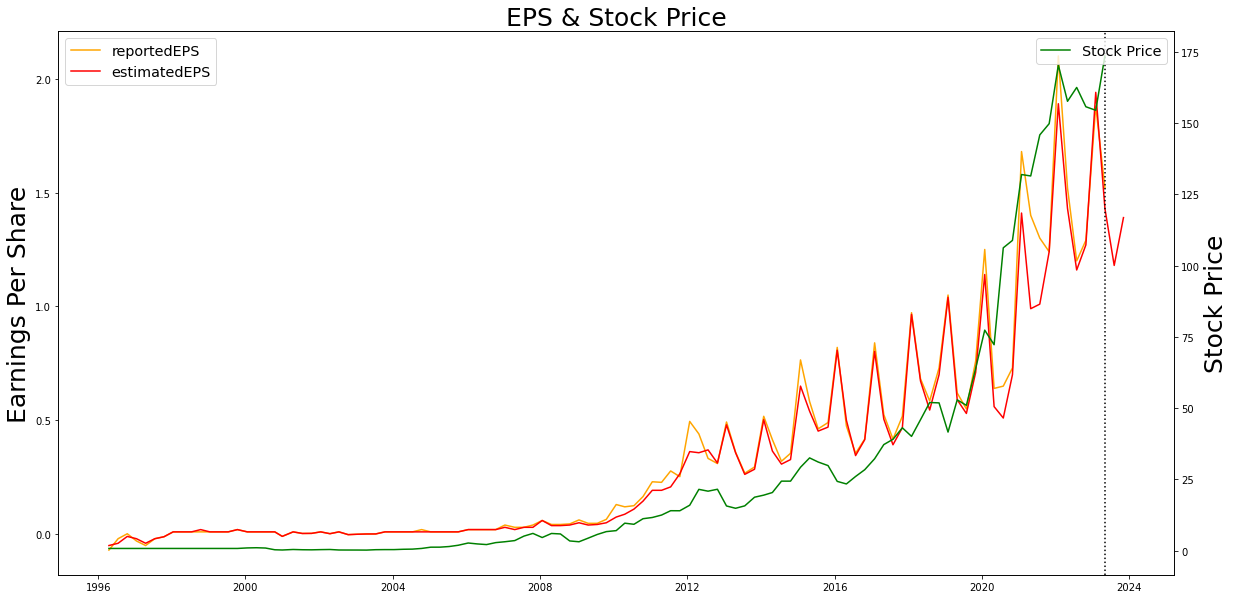




\ 


,Current Qtr (6/2023),Next Qtr (9/2023),Current Year (9/2023),Next Year (9/2024)
Period,,,,
Current,1.18,1.39,5.99,6.64
7 Days Ago,1.18,1.39,5.99,6.66
30 Days Ago,1.22,1.42,6.03,6.68
60 Days Ago,1.24,1.43,6.04,6.68
90 Days Ago,1.25,1.43,6.05,6.63


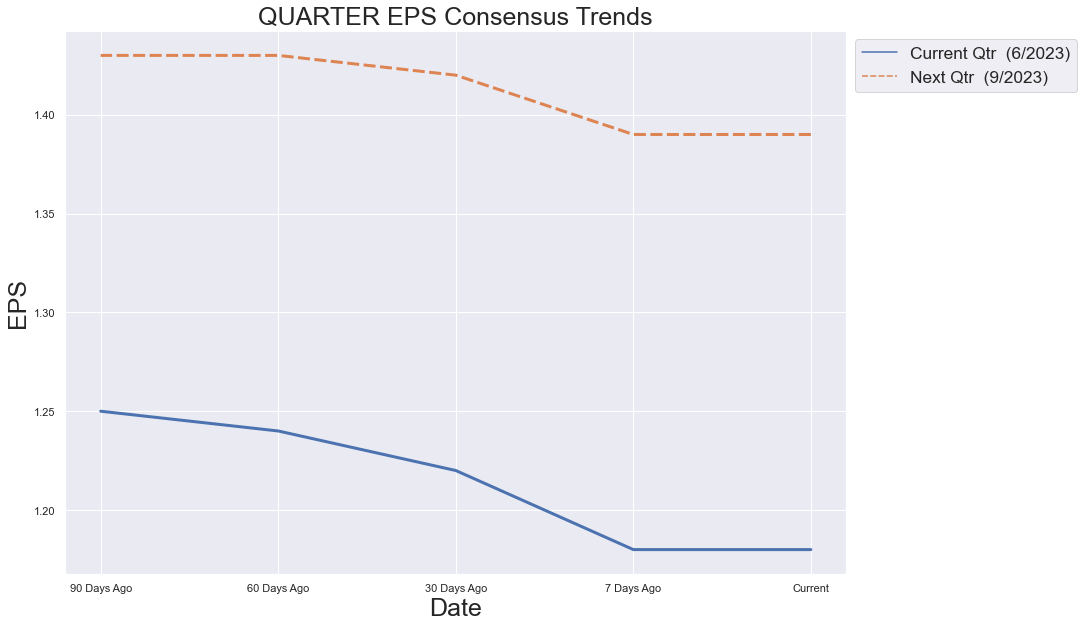

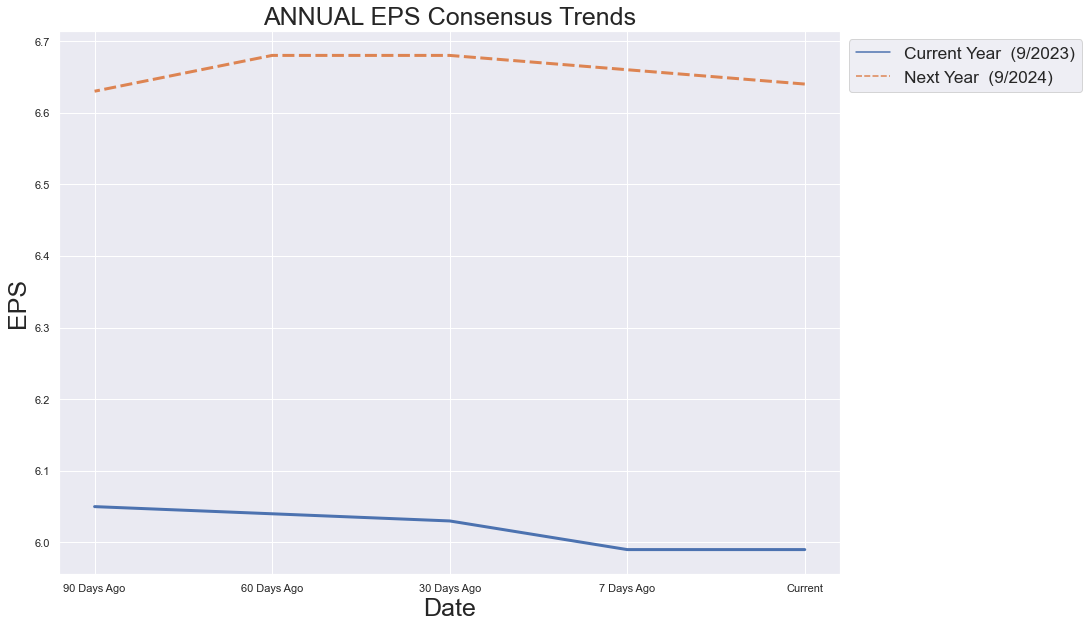

In [1]:
import pandas as pd
import alpha_vantage
import csv
import requests
import warnings
import math
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import requests
from bs4 import BeautifulSoup
warnings.simplefilter('ignore')
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 50)

api_key = ('QFZF2CEU5FAI6YIW')
sym = input("Input your stock ticker: ")

class calls:
    
    @staticmethod
    def get_weekly_data():
        
        ts = TimeSeries(key= api_key, output_format = 'pandas')
        df, meta_data = ts.get_weekly(symbol = sym.upper())

        df.reset_index(inplace = True)
        df['date'] = pd.to_datetime(df['date'])
        df.rename(columns = {'date': 'reportedDate'}, inplace = True)
        df = df.sort_values(by = 'reportedDate')
        
        return(df)
    
    @staticmethod
    def merge_weekly_stock(frame, df, kicker): # merge stock earnings, with weekly data. Insert columns
                
        frame.sort_values(by = 'fiscalDateEnding', inplace = True)
        
        if kicker == 'TRUE':
            frame.rename(columns = {'fiscalDateEnding': 'reportedDate'}, inplace = True)
             #create Free Cash Flow 
            frame = frame.replace('None', 0)
            frame['FreeCashFlow'] = frame['operatingCashflow'] - frame['capitalExpenditures']            
        else:
            pass
            
        new_df = pd.merge_asof(frame, df, on='reportedDate', direction='nearest')

        # add in the most up to date stock price as the final column
        end_stock_date = df['reportedDate'][0]
        end_stock_val = df['4. close'][0]

        # create the dict with to be the final row with proper date, & stock close. 
        keys = list(new_df.columns)
        d = {key: None if key != '4. close' else end_stock_val for key in keys}
        d['reportedDate']= end_stock_date
        
        new_df = new_df.append(d, ignore_index = True)
        
        return(new_df)
    
    @staticmethod
    def statement(statement):
        
        url = f'https://www.alphavantage.co/query?function={statement}&symbol={sym.upper()}&apikey={api_key}'
    
        if statement == 'CASH_FLOW':
    
            r = requests.get(url)

            if r.status_code == 200:
                try:
                    cf_annual = pd.DataFrame(r.json()['annualReports'])
                except:
                    print('Annual Reports do not exist in cash flow call')
                try:
                    cf_quarterly = pd.DataFrame(r.json()['quarterlyReports'])
                except:
                    print('Quarterly Reports do not exist in cash flow call')
                    

                cf_quarterly[['paymentsForRepurchaseOfCommonStock', 'capitalExpenditures', 'operatingCashflow']] = cf_quarterly[['paymentsForRepurchaseOfCommonStock', 'capitalExpenditures', 'operatingCashflow']].replace('None', 0)
                cf_annual[['paymentsForRepurchaseOfCommonStock', 'capitalExpenditures', 'operatingCashflow']] = cf_annual[['paymentsForRepurchaseOfCommonStock', 'capitalExpenditures', 'operatingCashflow']].replace('None', 0)
                
#                 quarter_mapping = {
#                     12: 'Q1',
#                     3: 'Q2',
#                     6: 'Q3',
#                     9: 'Q4'
#                 }

#                 # Map month values to quarters
#                 cf_quarterly['Quarter'] = cf_quarterly['fiscalDateEnding'].dt.month.map(quarter_mapping)
    
        
                return(cf_annual, cf_quarterly)
            
        elif statement == 'EARNINGS':
            
                r = requests.get(url)
                data = r.json()

                if statement == 'EARNINGS':
                    annual = pd.DataFrame(data['annualEarnings'])
                    quarterly = pd.DataFrame(data['quarterlyEarnings'])
                    annual['weekly'] = annual['fiscalDateEnding'].str[:7]
                    quarterly['weekly'] = quarterly['reportedDate'].str[:7]
                else:    
                    annual = pd.DataFrame(data['annualReports'])
                    quarterly = pd.DataFrame(data['quarterlyReports'])


                # For rows with none replace with np.nan. Then replace 'reportedEPS' with 'estimatedEPS' if NaN. 
                quarterly = quarterly.replace('None', np.nan)
                quarterly['estimatedEPS'].fillna(quarterly['reportedEPS'], inplace=True)
                annual = annual.replace('None', np.nan)     
                
                quarterly['reportedEPS'] = quarterly['reportedEPS'].astype(float)
                
                quarterly['reportedEPS_diff'] = quarterly['reportedEPS'].diff()
#                 annual['reportedEPS_diff'] = annual['reportedEPS'].diff()

                return(annual, quarterly)
        
    @staticmethod   
    def fix_dtypes(frame):
                        
        #change date_cols to datetime using regex
        date_cols = list(frame.filter(regex=re.compile('date', re.IGNORECASE)).columns)
        
#         if (frame.equals(cf_quarterly)) or (frame.equals(cf_annual)):
#             frame[['paymentsForRepurchaseOfCommonStock', 'capitalExpenditures', 'operatingCashflow']] = frame[['paymentsForRepurchaseOfCommonStock', 'capitalExpenditures', 'operatingCashflow']].replace('None', 0)
#         else:
#             pass
        
        for i in date_cols:
            frame[i] = pd.to_datetime(frame[i])
        
        #get remaining columns try to change to float, if error occurs then assume a string
        other_cols = list(set(frame.columns) - set(date_cols))

        for i in other_cols:
            try:
                frame[i] = frame[i].astype(float)
            except ValueError:
                frame[i] = frame[i].astype(str)
    
    @staticmethod
    def scrape_splits():  # webscrape historical stock splits from said stock. 
        session = requests.Session()
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36',}
        url = 'https://www.stocksplithistory.com/?symbol={}'.format(sym.upper())
        response = session.get(url, headers= headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table', {'class': 'split-history-table'})
        td_tags = soup.find_all('td', {'align': 'center', 'style': 'padding: 4px; border-bottom: 1px solid #CCCCCC'})


        date_list = []
        split_list = []

        for i in range(0, len(td_tags), 2):
            date = td_tags[i].text.strip()
            split = td_tags[i+1].text.strip()
            date_list.append(date)
            split_list.append(split)

        splits = pd.DataFrame({'Date': date_list, 'Split': split_list})
        splits['Date'] = pd.to_datetime(splits['Date'])
        splits_filt = splits.loc[splits['Date'] > '01/01/2000']
        return(splits_filt)
    
    @staticmethod
    def normalize_stock_splits(df, scrape): #normalize the dataframe. 

        i = 0
        while i < len(scrape):   

            split_string = list(scrape['Split'].values)[i]
            split_list = split_string.split("for")
            split_ratio = int(split_list[0].strip())

            split_date = scrape['Date'].values[i]
            split_date = pd.to_datetime(split_date)

            #filter for current week up to split & everything prior. 
            mask = ((df['reportedDate'].dt.year < split_date.year) | 
                ((df['reportedDate'].dt.year == split_date.year) & (df['reportedDate'].dt.week <= split_date.week)))
            split_df = df.loc[mask]


            split_df['1. open'] = split_df['1. open'] / split_ratio
            split_df['2. high'] = split_df['2. high'] / split_ratio
            split_df['3. low'] = split_df['3. low'] / split_ratio
            split_df['4. close'] = split_df['4. close'] / split_ratio


            df.update(split_df)
            i += 1
        
        return(df)
    
    @staticmethod
    def plot_EPS_stock():
        fig, ax1 = plt.subplots(figsize=(20, 10))
        ax2 = ax1.twinx()

        # plot the first line with the left y-axis
        sns.lineplot(x='reportedDate', y='reportedEPS', data=df_merged, ax=ax1, color = 'orange', label='reportedEPS')

        # plot the second line with the left y-axis
        sns.lineplot(x='reportedDate', y='estimatedEPS', data=df_merged, ax=ax1, color = 'red', label = 'estimatedEPS')

        # plot the third with the right y-axis
        sns.lineplot(x = 'reportedDate', y = '4. close', data = df_merged, color = 'green', label = 'Stock Price')

        ax1.set_xlabel('')
        ax1.set_ylabel('Earnings Per Share', fontsize=25)
        ax2.set_ylabel('Stock Price', fontsize=25)
        ax1.set_title('EPS & Stock Price', fontsize = 25)

        # adjust the position of the legends
        ax1.legend(loc='upper left', fontsize = 'x-large')
        ax2.legend(loc='upper right', fontsize = 'x-large')

        last_date = df_merged['reportedDate'].iloc[-3]
        ax1.axvline(x=last_date, linestyle='dotted', color='black')

        ax1.invert_yaxis()

        plt.show() #EPS vs Stock Plot
        
    @staticmethod
    def get_next_numbers():  #scraping future earnings
    
        session = requests.Session()
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36',}

        url = 'https://www.zacks.com/stock/quote/{}/detailed-earning-estimates'.format(sym.upper())
        response = session.get(url, headers = headers)

        soup = BeautifulSoup(response.content, 'html.parser')

        tags = soup.find_all('a', href='/stock/chart/{}/price-consensus-eps-surprise-chart'.format(sym.upper()))

        number_values = []
        for tag in tags:
            text = tag.text
            number_values.append(text)

        t = soup.find_all('th', {'class': ''})

        tag_list = []
        for tags in t:
            tag_list.append(tags.text)

        t = pd.DataFrame(tag_list, columns = ['Tags'])
        t = pd.DataFrame(t['Tags'].drop_duplicates())
        t = t[t['Tags'].str.contains('Qtr|Year')]

        frame = {'Revenue': number_values[1:5],
                'EPS': number_values[6:10]}

        index = list(t['Tags'][0:4].values)
        scrape = pd.DataFrame(frame, index=index)
        #---------------------------------------

        tds = soup.find_all('td', {'class': 'alpha'})

        data = []       
        for td in tds:
            row = {}
            if td.text == 'Current' or td.text == '7 Days Ago' or td.text == '30 Days Ago' or td.text == '60 Days Ago' or td.text == '90 Days Ago':
                row['Period'] = td.text
                row['Value1'] = td.find_next_siblings('td')[0].text
                row['Value2'] = td.find_next_siblings('td')[1].text
                row['Value3'] = td.find_next_siblings('td')[2].text
                row['Value4'] = td.find_next_siblings('td')[3].text
                data.append(row)

        consensus = pd.DataFrame(data)
        consensus.set_index('Period', inplace = True)
        col_dict = dict(zip(list(consensus.columns), index))
        consensus = consensus.rename(columns = col_dict)

        return(scrape, consensus)
    
    @staticmethod
    def insert_proj_EPS(current_or_next, frame, proj): #insert projected EPS
    
        #get the last record of earnings quarterly and offset by 3 months
        fiscal_val = frame.iloc[len(frame) -1]['fiscalDateEnding']
        reported_val = frame.iloc[len(frame) -1]['reportedDate']
        offset = pd.DateOffset(months = 3)

        fiscal_date_end = fiscal_val+offset
        reported_date_end = reported_val + offset

        if current_or_next == 'current':
            qtr = proj['EPS'][0]
        elif current_or_next == 'next':
            qtr = proj['EPS'][1]
        else:
            print('Error with naming convention')


        first_row = pd.DataFrame({
            'fiscalDateEnding': [fiscal_date_end],
            'reportedDate': [reported_date_end],
            'reportedEPS': [None],
            'estimatedEPS': [qtr],
            'surprise': [0],
            'surprisePercentage': [0],
            'weekly': ['2023']
        })

        if current_or_next == 'current':
            frame.loc[-1] = first_row.iloc[0]
        elif current_or_next == 'next':
            frame.loc[-2] = first_row.iloc[0]
        else:
            print('Error with row update')
            
    @staticmethod
    def estimates(consensus, quarter_or_annual):  #linechart of consensus estimates EPS
    
        consensus[list(consensus.columns)] = consensus[list(consensus.columns)].astype(float)

        if quarter_or_annual == 'quarter':
            consensus = consensus.iloc[:, :2]
        elif quarter_or_annual == 'annual':
            consensus = consensus.iloc[:, 2:4]
        else:
            print('wrong input')

        sns.set(style="darkgrid")
        plt.figure(figsize=(14, 10))
        ax = sns.lineplot(data=consensus,linewidth=3.0)

        ax.invert_xaxis()

        # Set the title and labels
        plt.title(f'{quarter_or_annual.upper()} EPS Consensus Trends', fontsize = 25)
        plt.xlabel('Date', fontsize = 25)
        plt.ylabel('EPS', fontsize = 25)
        plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

        # Display the chart
        plt.show()
    
# -----------------------------------------------------------------------------------------------------------------------           
    
def process_data(statement):   
    # load the initial data into the frames
    
    if statement == 'CASH_FLOW':
    
        df = calls.get_weekly_data()
        cf_annual, cf_quarterly = calls.statement(statement)

        # fix data types in place
        calls.fix_dtypes(cf_annual)
        calls.fix_dtypes(cf_quarterly)  

        # scrape and normalize stock splits
        scrape = calls.scrape_splits()
        df = calls.normalize_stock_splits(df, scrape)
        df_merge = calls.merge_weekly_stock(cf_quarterly, df, 'TRUE')
        
        return(df_merge, df)
        
    elif statement == 'EARNINGS':
        
        df = calls.get_weekly_data()
        earnings_annual, earnings_quarterly = calls.statement(statement)

        calls.fix_dtypes(earnings_annual)
        calls.fix_dtypes(earnings_quarterly)

        scrape = calls.scrape_splits()
        df = calls.normalize_stock_splits(df, scrape)
        df_merged = calls.merge_weekly_stock(earnings_quarterly, df, 'FALSE')
        
        #drop last row with close data
        df_merged = df_merged.drop(len(df_merged) - 1)
        df_merged['reportedEPS_diff'] = df_merged['reportedEPS'].diff()
        
        proj, consensus = calls.get_next_numbers()
        
        calls.insert_proj_EPS('current', df_merged, proj)
        calls.insert_proj_EPS('next', df_merged, proj)   
        
        return(df_merged, df, proj, consensus)
    
    else:
        print("issue")
    
    
df_merged, df_2, proj, consensus = process_data('EARNINGS')
df_merged_2, df_2_ = process_data('CASH_FLOW')
    
print(f"Last reported EPS: {df_merged.iloc[-3]['reportedEPS']} on {str(df_merged.iloc[-3]['reportedDate'])[:10]}")
display(proj)
calls.plot_EPS_stock()
print('\n\n\n\ ')
display(consensus)
calls.estimates(consensus, 'quarter')
calls.estimates(consensus, 'annual')

# demonstrate what months are the peak and trough for earnings right here. 

,correlation
1997,0.593358
1998,NaN
1999,-0.500104
2000,-0.882464
2001,-0.272353
2002,0.238199
2003,-0.025177
2004,-0.500104
2005,0.882464
2006,0.882464



Average correlation value 0.63
Average correlation value of last 15 years: 0.96


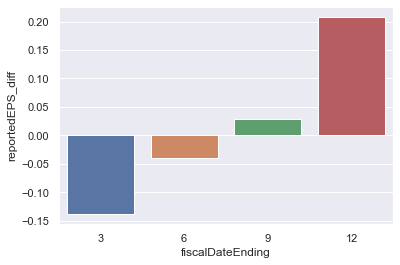

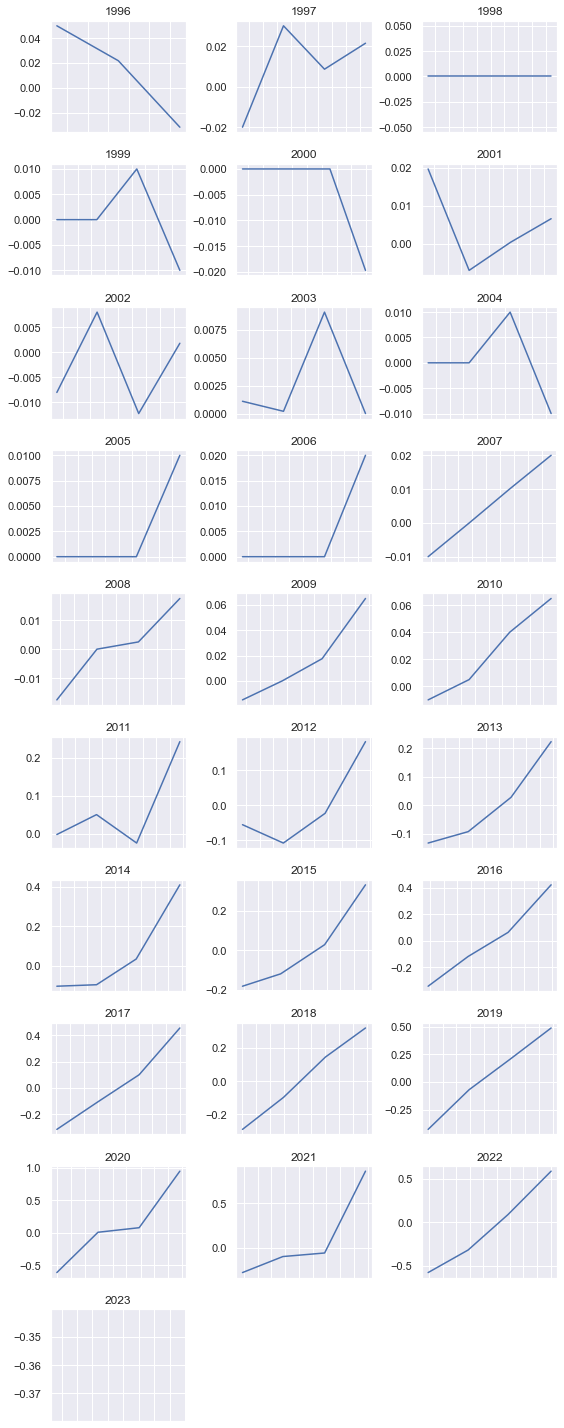

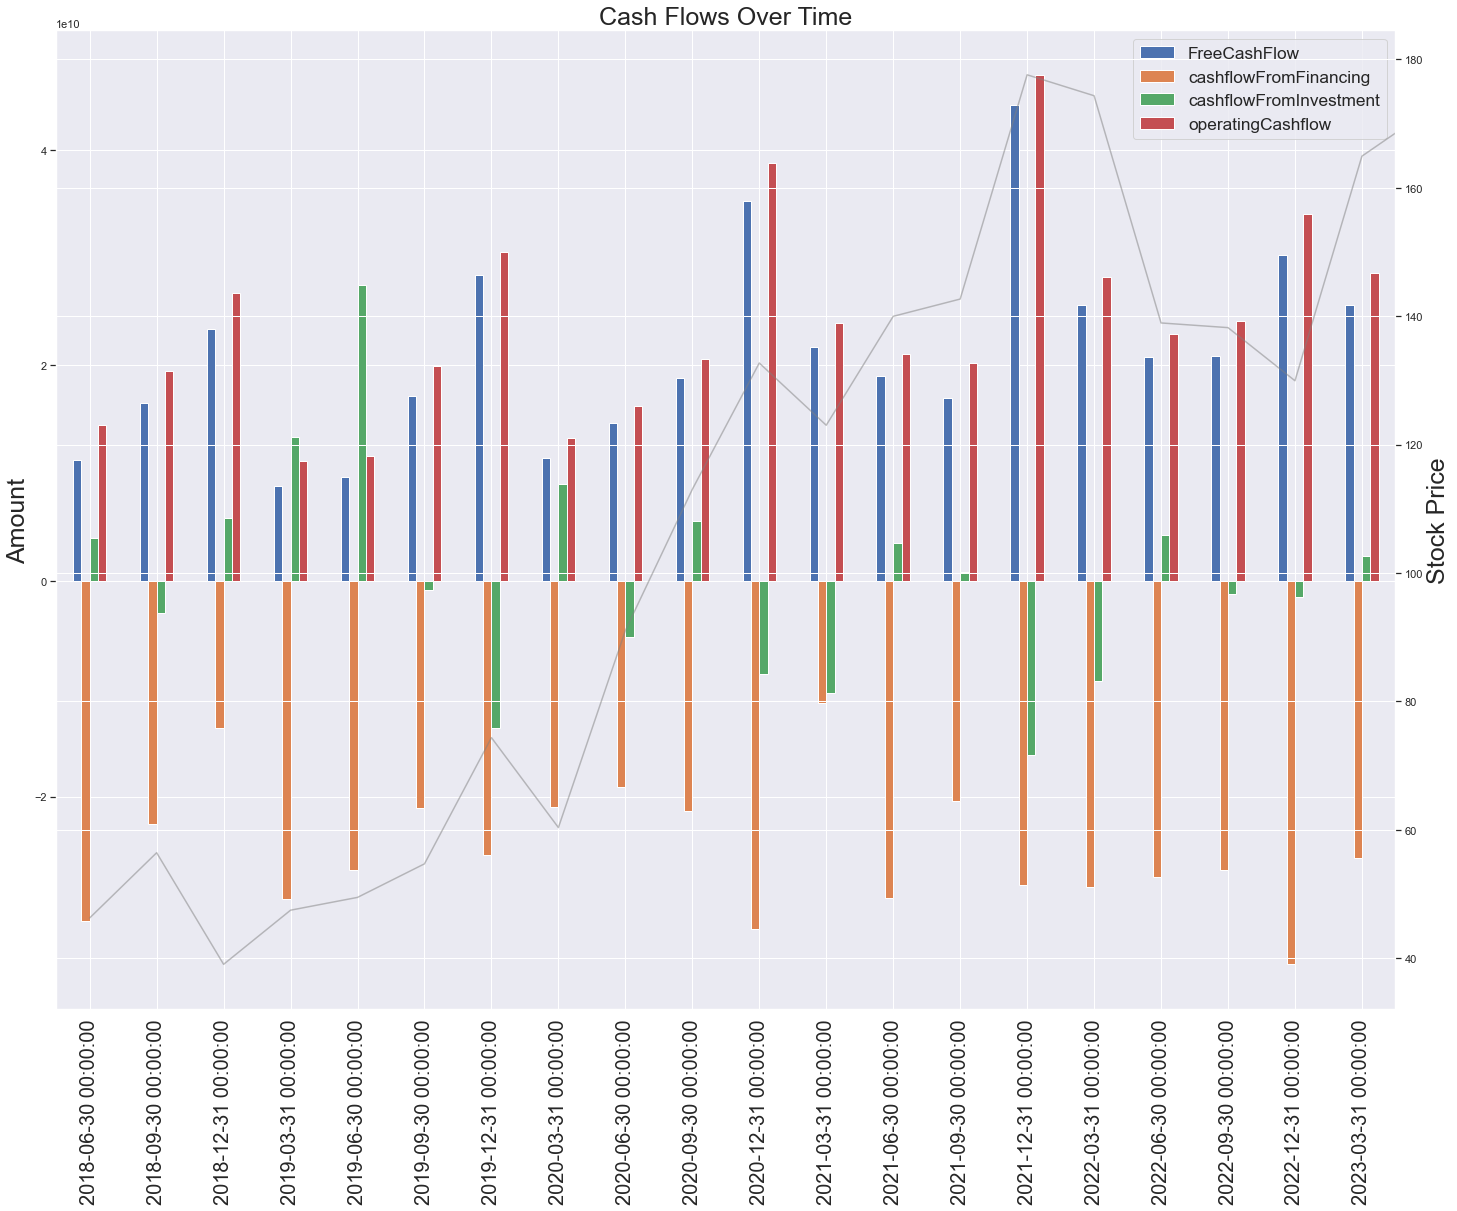

,operatingCashflow_YoY,cashflowFromInvestment_YoY,cashflowFromFinancing_YoY,FreeCashFlow_YoY
reportedDate,,,,
2018-06-30,NaN,NaN,NaN,NaN
2018-09-30,NaN,NaN,NaN,NaN
2018-12-31,NaN,NaN,NaN,NaN
2019-03-31,NaN,NaN,NaN,NaN
2019-06-30,-0.196853,5.967824,-0.149700,-0.141253
2019-09-30,0.019823,-0.734089,-0.068246,0.039498
2019-12-31,0.143350,-3.338809,0.857780,0.217442
2020-03-31,0.193277,-0.324768,-0.289133,0.303230
2020-06-30,0.398333,-1.187805,-0.286823,0.526152


In [8]:
def EPS_cycle():
    sub = df_merged[['fiscalDateEnding', '4. close', 'reportedEPS', 'reportedEPS_diff']]
    sub['reportedEPS'] = sub['reportedEPS'].astype(float)

    output = sub.groupby(sub['fiscalDateEnding'].dt.month)[['reportedEPS_diff']].mean()
    output.reset_index(inplace =True)
    return(output)

out = EPS_cycle()
sns.barplot(x='fiscalDateEnding', y='reportedEPS_diff', data=out);

# ----------------------------------------------------------------------Show subplot of YoY EPS---------------------------

def plot_change(column):
    
    frame = df_merged
    frame['year'] = frame['fiscalDateEnding'].dt.year
    years = list(frame['fiscalDateEnding'].dt.year.unique())

    # Calculate the number of rows and columns needed based on the number of years
    n_rows = (len(years) - 1) // 3 + 1
    n_cols = min(len(years), 3)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 2*n_rows))



    # Loop over the subplots and plot each year's data
    for i, n in enumerate(years):
        subset = frame.loc[frame['fiscalDateEnding'].dt.year == years[i]]

        row = i // n_cols
        col = i % n_cols
    
        sns.lineplot(data=subset, x='reportedDate', y=column,  ax=axs[row, col])
        #sns.scatterplot(data=subset, x='reportedDate', y=column, ax=axs[row, col], s=50, linewidth=1, edgecolor='black', zorder=3)
        axs[row, col].set_title(years[i])
        axs[row, col].set_xlabel(None)
        axs[row, col].set_ylabel(None)
        axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45)

#     Remove any unused subplots
    for i in range(len(years), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        fig.delaxes(axs[row, col])

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------Correlation Average-------------------------------------

def correlation_average():

    years = list(df_merged['fiscalDateEnding'].dt.year.unique())

    for i in years:
            small = df_merged.loc[df_merged['fiscalDateEnding'].dt.year == i]
            small['reportedEPS_diff'] = small['reportedEPS_diff'].astype(float)
            try:
                out[str(i)] = small['reportedEPS_diff'].values
            except ValueError:
                pass

    corr_list = []
    year_list = []

    for year in years:
            try:

                correlation, p_value = stats.pearsonr(out['reportedEPS_diff'], out[str(year)])
                corr_list.append(correlation)
                year_list.append(year)
            except ValueError:
                pass
            except KeyError:
                pass
            
    corr_frame = pd.DataFrame(corr_list, index=year_list, columns=['correlation'])
    display(corr_frame)

    a = [x for x in corr_list if not math.isnan(x)]
    a_15 = [a[-15:]]
    a_15 = [item for sublist in a_15 for item in sublist]

    a = (sum(a) / len(a))
    a_15 = (sum(a_15) / len(a_15))
    print(f'\nAverage correlation value {round(a, 2)}')
    print(f'Average correlation value of last 15 years: {round(a_15, 2)}')
    
correlation_average()  
plot_change('reportedEPS_diff')

# Plot this trend out year over year with this box at the top

#--------------------------------------------------------------CASH FLOWS-------------------------------------------------

def cash_flows():

    df_sub = df_merged_2[['reportedDate','operatingCashflow', 'cashflowFromInvestment', 'cashflowFromFinancing', 'FreeCashFlow']]

    # Remove the last row with NaN values
    df_sub = df_sub[:-1]

    # Melt the dataframe to create a long-form dataframe
    df_long = pd.melt(df_sub, id_vars=['reportedDate'], var_name='Cash Flow', value_name='Amount')

    # Create the bar chart using matplotlib
    fig, ax = plt.subplots(figsize=(24, 18))
    df_long.pivot(index='reportedDate', columns='Cash Flow', values='Amount').plot(kind='bar', ax=ax)

    # Add axis labels and a title
    plt.xlabel('')
    plt.ylabel("Amount",fontsize = 25 )
    plt.title("Cash Flows Over Time", fontsize = 25)

    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    ax.legend(fontsize='x-large')
    
#         ax1.legend(loc='upper left', fontsize = 'x-large')
#     ax2.legend(loc='upper left', fontsize = 'x-large', bbox_to_anchor=(0, 0.9))
    
    ax2 = ax.twinx()
    df_merged_2['4. close'].plot(ax=ax2, color='gray', alpha=0.5)
    ax2.set_ylabel("Stock Price", fontsize = 25)
#     ax2.set_ylim(ax.get_ylim())

    plt.show()

    # Set the reportedDate column as the index
    df_sub.set_index('reportedDate', inplace=True)

    # Extract the cashflow columns into a separate dataframe
    cf_df = df_sub.loc[:, 'operatingCashflow':'FreeCashFlow']

    # Calculate the YoY change for each cashflow metric
    cf_yoy_df = cf_df.pct_change(periods=4)

    # Rename the columns
    cf_yoy_df.columns = [col + '_YoY' for col in cf_yoy_df.columns]
    
    display(cf_yoy_df)
    
cash_flows()


# Cash Flow From Invesment

Cash flow from investments refers to the amount of cash inflow or outflow generated from a company's investments in assets, such as property, equipment, securities, or other investments. Here are some examples of cash flow from investment:

Purchase of property: When a company purchases a property, the cash outflow from the investment will be recorded as a negative cash flow from investment.

Sale of property: When a company sells a property, the cash inflow from the sale will be recorded as a positive cash flow from investment.

Purchase of equipment: When a company purchases new equipment, the cash outflow from the investment will be recorded as a negative cash flow from investment.

Sale of equipment: When a company sells equipment, the cash inflow from the sale will be recorded as a positive cash flow from investment.

Purchase of securities: When a company purchases securities, such as stocks or bonds, the cash outflow from the investment will be recorded as a negative cash flow from investment.

Sale of securities: When a company sells securities, the cash inflow from the sale will be recorded as a positive cash flow from investment.

Dividend income: When a company receives dividends from its investments, the cash inflow from the dividend income will be recorded as a positive cash flow from investment.

Interest income: When a company receives interest on its investments, the cash inflow from the interest income will be recorded as a positive cash flow from investment.

# Cash Flow From Financing

Cash flow from financing refers to the inflow and outflow of cash resulting from a company's financing activities, such as borrowing money, issuing stock, or paying dividends to shareholders. These activities affect the company's capital structure and the overall amount of debt and equity that the company holds.

Here are some examples of cash flow from financing:

Issuing new stock: When a company issues new shares of stock, the cash inflow from the sale of those shares is recorded as a positive cash flow from financing.

Repurchasing stock: When a company buys back its own stock, the cash outflow from the repurchase is recorded as a negative cash flow from financing.

Issuing debt: When a company borrows money through issuing bonds or taking out loans, the cash inflow from the debt issuance is recorded as a positive cash flow from financing.

Repaying debt: When a company pays off its debt, the cash outflow from the repayment is recorded as a negative cash flow from financing.

Paying dividends: When a company pays dividends to its shareholders, the cash outflow from the payment is recorded as a negative cash flow from financing.

The net result of cash flow from financing activities can indicate whether a company is funding its operations through debt or equity, and whether it is generating enough cash to pay its obligations or requires additional financing to continue operating. Investors and analysts use this information to evaluate a company's financial health and investment potential.



